In [1]:
!pip install pymorphy2

In [3]:
"""Импорт необходимых библиотек"""

import requests as rq
import pandas as pd
import numpy as np
import json
import time
import string
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from pymorphy2 import MorphAnalyzer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Артём\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
"""Исходная база данных"""

vac_df = pd.read_csv('./final_baza.csv')
vac_df.head()

,Unnamed: 0,id,name,s_description,s_key_skills,s_specializations,d_professional_roles,area.id,area.name,salary.from,salary.to,salary.currency,address.lat,address.lng,experience.name,schedule.name,employment.name
0,0,24720534,Системный/бизнес-аналитик,компания ао strong нпо русбитех требовать...,NaN,реинжиниринг бизнес процесс консульт...,аналитик,1,Москва,NaN,NaN,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость
1,1,30185978,Системный аналитик,делать автомобиль доступными strong p ты ин...,NaN,программирование разработка информац...,аналитик,1,Москва,NaN,NaN,NaN,55.728849,37.620321,От 1 года до 3 лет,Удаленная работа,Полная занятость
2,2,30649371,Инженер-аналитик (контент SIEM),предстоять strong p участие проект направлен...,NaN,компьютерный безопасность информацио...,аналитик,2,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,От 1 года до 3 лет,Гибкий график,Полная занятость
3,3,31069427,Системный аналитик (Тинькофф Страхование),искать аналитика развитие платформа прямой про...,NaN,системный интеграция информационный ...,аналитик,1,Москва,NaN,NaN,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость
4,4,33368305,Аналитик данных (Департамент закупок),связь развитие сеть структура отдел компания р...,ms excel анализ данные,финансовый анализ бухгалтерия управл...,аналитик,1,Москва,NaN,150000.0,RUR,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость


## 1 Блок объявления функций

### 1.1 Функция селекции по проф. роли
##### Принимает на вход значение проф. роли, создает и возвращает отдельный датафрейм со всеми вакансиями из этой роли. Пустые значения столбца 'key_skills' заполняются значением 'НЕТ_ДАННЫХ'. 

In [10]:
def role_df(role):     
    role_df = vac_df[vac_df['d_professional_roles'] == role] 
    role_df = role_df.iloc[:, [2,6,4,3]]
    role_df['s_key_skills'] = role_df['s_key_skills'].fillna("НЕТ_ДАННЫХ")
    return role_df

### 1.2 Функция счетчика по словам
##### Принимает на вход текст/строку/массив, разбивает его на отдельные слова и считает сколько раз встречалось в тексте каждое слово. Принимает на вход значение частоты в %, ниже которого слова не учитываются. Формирует и возвращает словарь с ключами из слов и значениями из частоты. Дополнительно можно задать условия вывода - проценты, цифра с плавающей точкой, абсолютное значение. 

In [11]:
def word_freq(text, perc, ret):     
    amount = {}
    min_amount = len(text) * perc/100        #минимальный порог того, в скольки % вакансий должен встречаться токен
    for sentence in text:  
        for word in word_tokenize(sentence):  
            if word not in amount:
                amount[word] = 0 
            amount[word] += 1
    if ret == '%':     
        return {x:"{0:.0%}".format(y/len(text)) 
                for x,y in sorted(amount.items(), key=lambda xy: xy[1], reverse=True) if y > min_amount}
    elif ret == ".":
        return {x:round(y/len(text)*100, 1) 
                for x,y in sorted(amount.items(), key=lambda xy: xy[1], reverse=True) if y > min_amount} 
    else:
        return {x:y for x,y in sorted(amount.items(), key=lambda xy: xy[1], reverse=True) if y > min_amount} 
    


### 1.3 Функция получения словаря основных ключевых навыков
##### Принимает на вход строку из основных ключевых навыков, формирует из неё словарь и возвращает.

In [12]:
def get_main_mass (key_mass, tokens_mass):    
    main_mass = {}
    for i in key_mass:
        main_mass [i] = tokens_mass [i]
    return main_mass

### 1.4 Функция сортировки словаря по значениям
##### Принимает на вход словарь. Переводит его в формат списка и выполняет сортировку по значениям. Переводит полученный список обратно в словарь и возвращает его.

In [13]:
def sort_dict(dictionary):    
    list_dict = list(dictionary.items())
    list_dict.sort(key=lambda i: i[1], reverse=True)
    list_dict = dict(list_dict)
    return list_dict

In [14]:
plt.rcParams['font.size'] = '15'

## 2 Распределение вакансий по городам

In [15]:
vac_df['area.name'].value_counts()

Москва                            15170
Санкт-Петербург                    2266
Новосибирск                        2222
Казань                             1625
Воронеж                            1192
                                  ...  
Мичуринский (Брянская область)        1
Берёзовый (Краснодарский край)        1
Усинск                                1
Лебедянь                              1
Ржев                                  1
Name: area.name, Length: 451, dtype: int64

In [19]:
area_name_df = word_freq(vac_df['area.name'], 1.5, "%")
area_name_df ['Другие'] = '25%'
area_name_df

{'Москва': '46%',
 'Санкт-Петербург': '7%',
 'Новосибирск': '7%',
 'Казань': '5%',
 'Воронеж': '4%',
 'Томск': '2%',
 'Омск': '2%',
 'Самара': '2%',
 'Другие': '25%'}

In [20]:
#colors = ['yellow','green','red','blue', "orange", "cyan", "brown", 
#aa = {k:int(v) for k, v in area_name_df.items()}
#aa = [area_name_df([a, int(x)] for a, x in area_name_df)]
#plt.pie(aa.values(), list(aa.keys()))

## 3 Распределение вакансий по проф. ролям

In [21]:
vac_df ['d_professional_roles'].value_counts()

программист разработчик                    13622
аналитик                                    7130
специалист технической поддержки            3718
системный администратор                     2276
специалист информационной безопасности      2124
тестировщик                                 1890
руководитель группы разработки              1319
системный инженер                            540
гейм дизайнер                                159
директор информационным технологиям cio      122
оператор пк оператор базы данных              85
Name: d_professional_roles, dtype: int64

### 3.1 Аналитик

In [22]:
analyst_df = role_df('аналитик')     #создаем дф для проф. роли 'Аналитик'

analyst_ks_tokens = word_freq(analyst_df['s_key_skills'].to_list(), 5, '.')     

print('Слова встречаются в разделе "ключевые навыки" в %')
analyst_ks_tokens

Слова встречаются в разделе "ключевые навыки" в %


{'sql': 53.1,
 'анализ': 51.5,
 'ms': 40.7,
 'бизнес': 28.8,
 'данные': 19.9,
 'системный': 18.4,
 'аналитический': 18.3,
 'работа': 18.3,
 'мышление': 17.2,
 'разработка': 15.6,
 'НЕТ_ДАННЫХ': 15.1,
 'python': 14.6,
 'bpmn': 14.4,
 'процесс': 12.9,
 'язык': 12.8,
 'технический': 12.7,
 'atlassian': 12.5,
 'управление': 12.4,
 'uml': 12.4,
 'английский': 12.4,
 'задание': 11.2,
 'sap': 10.6,
 'powerpoint': 10.0,
 'jira': 8.9,
 'информация': 8.8,
 'с': 8.7,
 'база': 8.6,
 'моделирование': 7.5,
 'проект': 7.4,
 'аналитик': 7.4,
 'bi': 7.4,
 'visio': 7.2,
 'power': 6.8,
 'больший': 6.5,
 'объём': 6.3,
 'excel': 6.2,
 'data': 6.1,
 'команда': 5.8,
 'разработчик': 5.6,
 'задача': 5.6,
 'постановка': 5.6,
 'confluence': 5.5,
 'xml': 5.3,
 'математический': 5.2,
 'исследование': 5.1,
 'oracle': 5.1}

In [81]:
analyst_ks_mass = ['sql','НЕТ_ДАННЫХ','python','bpmn','atlassian','uml','английский','sap','powerpoint','jira','visio','excel',
                  'confluence','xml','oracle']

analyst_ks_main = get_main_mass(analyst_ks_mass, analyst_ks_tokens)
analyst_ks_main['английский язык'] = analyst_ks_main.pop('английский')
analyst_ks_main = sort_dict(analyst_ks_main)

print('Наиболее часто всречающиеся ключевые навыки в разделе "Аналитик" в %')
analyst_ks_main

Наиболее часто всречающиеся ключевые навыки в разделе "Аналитик" в %


{'sql': 53.1,
 'НЕТ_ДАННЫХ': 15.1,
 'python': 14.6,
 'bpmn': 14.4,
 'atlassian': 12.5,
 'uml': 12.4,
 'английский язык': 12.4,
 'sap': 10.6,
 'powerpoint': 10.0,
 'jira': 8.9,
 'visio': 7.2,
 'excel': 6.2,
 'confluence': 5.5,
 'xml': 5.3,
 'oracle': 5.1}

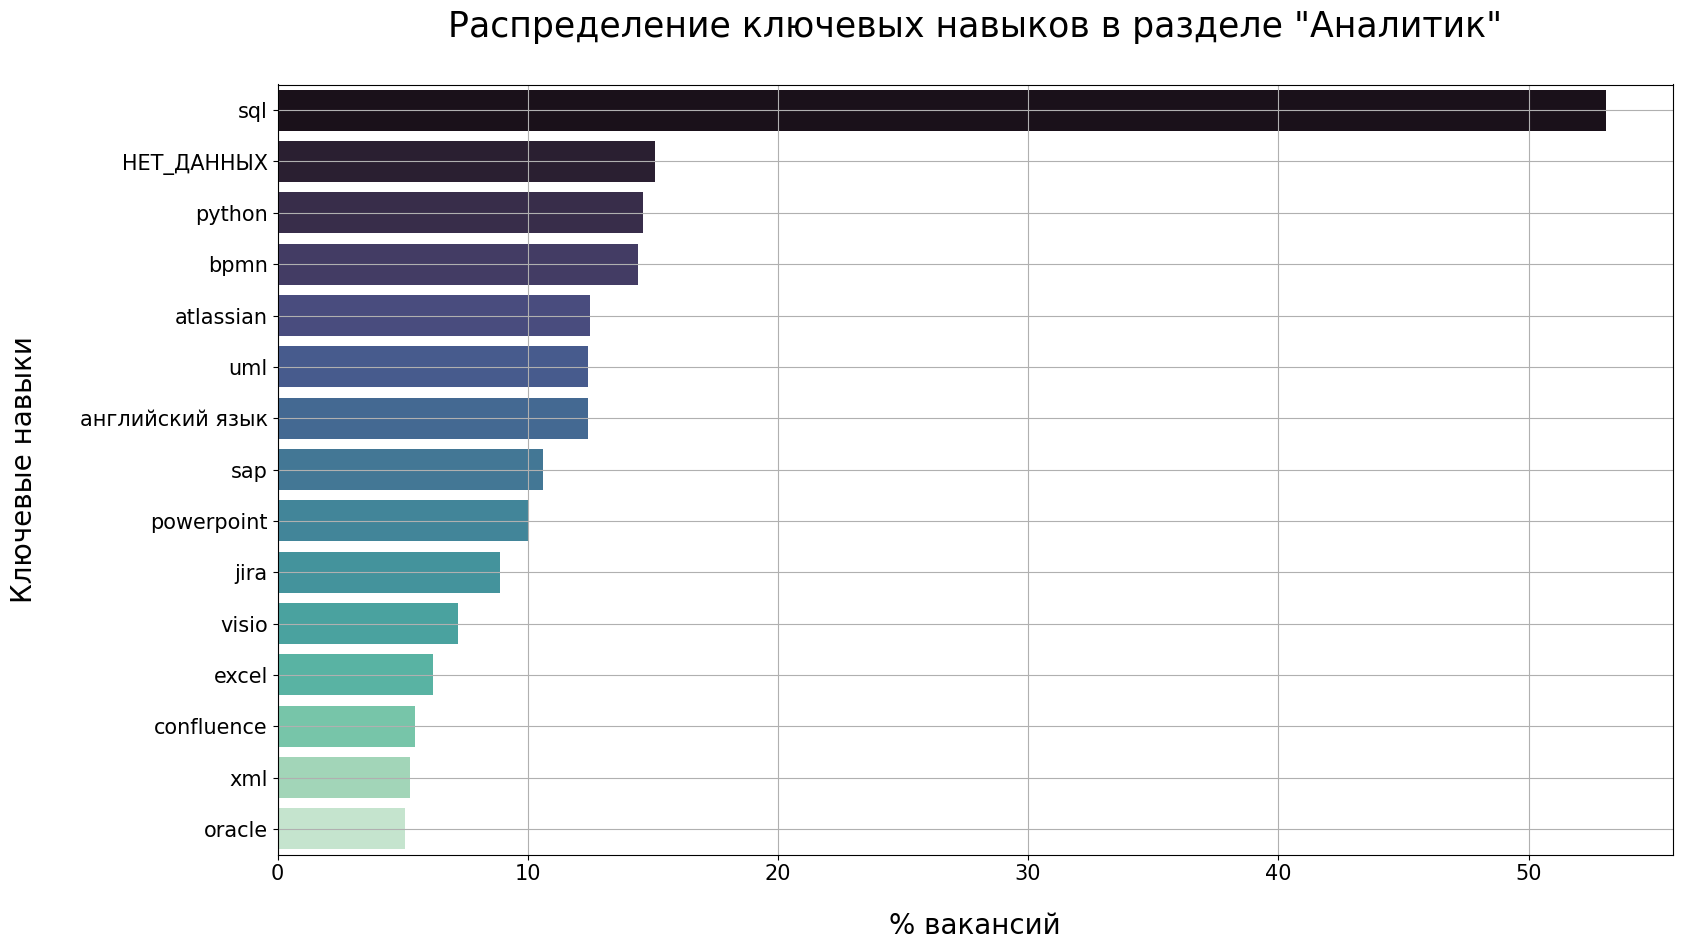

In [163]:
plt.figure(figsize=(18, 10))
sns.barplot(y=list(analyst_ks_main.keys()), x=list(analyst_ks_main.values()), palette="mako")
plt.title('Распределение ключевых навыков в разделе "Аналитик"\n', fontsize=25)
plt.xlabel('% вакансий', fontsize=20, labelpad=20)
plt.ylabel('Ключевые навыки', fontsize=20,labelpad=30)
plt.grid('on')
plt.savefig('Аналитик.png')
plt.show()

### 3.2 Тестировщик

In [25]:
test_df = role_df('тестировщик')     #создаем дф для проф. роли 'Тестировщик'

test_ks_tokens = word_freq(test_df['s_key_skills'].to_list(), 2, '.')

print('Слова встречаются в разделе "ключевые навыки" в %')
test_ks_tokens

Слова встречаются в разделе "ключевые навыки" в %


{'тестирование': 104.3,
 'sql': 40.6,
 'функциональный': 23.5,
 'atlassian': 23.2,
 'jira': 21.0,
 'НЕТ_ДАННЫХ': 18.7,
 'qa': 16.9,
 'git': 16.3,
 'java': 15.4,
 'python': 13.5,
 'linux': 12.8,
 'интерфейс': 11.6,
 'пользовательский': 11.5,
 'язык': 11.0,
 'английский': 10.9,
 'test': 10.8,
 'case': 9.8,
 'api': 8.6,
 'selenium': 7.4,
 'проведение': 7.1,
 'rest': 6.6,
 'html': 6.5,
 'регресcионный': 6.1,
 'c': 5.6,
 'ms': 5.4,
 'postman': 5.3,
 'android': 5.3,
 'работа': 5.0,
 'testing': 4.7,
 'ios': 4.7,
 'soap': 4.6,
 'xml': 4.4,
 'confluence': 4.4,
 'команда': 4.2,
 'javascript': 4.1,
 'scrum': 3.6,
 'нагрузочный': 3.5,
 'ручной': 3.0,
 'управление': 2.9,
 'agile': 2.8,
 'ide': 2.8,
 'аналитический': 2.7,
 'css': 2.7,
 'регресионный': 2.6,
 'мышление': 2.5,
 'postgresql': 2.4,
 'jmeter': 2.4,
 'jenkins': 2.3,
 'разработка': 2.2,
 'project': 2.2,
 'management': 2.2,
 'автоматизация': 2.1,
 'docker': 2.1,
 'kotlin': 2.1}

In [26]:
test_ks_mass = ['sql','atlassian','jira','НЕТ_ДАННЫХ','git','java','python','английский','case','api','selenium','rest','html',
               'postman','soap','xml','confluence','javascript']              
test_ks_os_mass = ['linux','android','ios']
test_ks_type_mass = ['функциональный','регресcионный','нагрузочный','ручной']

test_ks_main = get_main_mass (test_ks_mass, test_ks_tokens)
test_ks_main['английский язык'] = test_ks_main.pop('английский')
test_ks_main = sort_dict(test_ks_main)

test_ks_os = get_main_mass (test_ks_os_mass, test_ks_tokens)

test_ks_type = get_main_mass (test_ks_type_mass, test_ks_tokens)
test_ks_type['функциональное'] = test_ks_type.pop('функциональный')
test_ks_type['регрессионное'] = test_ks_type.pop('регресcионный')
test_ks_type['нагрузочное'] = test_ks_type.pop('нагрузочный')
test_ks_type['ручное'] = test_ks_type.pop('ручной')
test_ks_type = sort_dict(test_ks_type)

print('Наиболее часто всречающиеся ключевые навыки в разделе "Тестировщик" в %')
test_ks_main

Наиболее часто всречающиеся ключевые навыки в разделе "Тестировщик" в %


{'sql': 40.6,
 'atlassian': 23.2,
 'jira': 21.0,
 'НЕТ_ДАННЫХ': 18.7,
 'git': 16.3,
 'java': 15.4,
 'python': 13.5,
 'английский язык': 10.9,
 'case': 9.8,
 'api': 8.6,
 'selenium': 7.4,
 'rest': 6.6,
 'html': 6.5,
 'postman': 5.3,
 'soap': 4.6,
 'xml': 4.4,
 'confluence': 4.4,
 'javascript': 4.1}

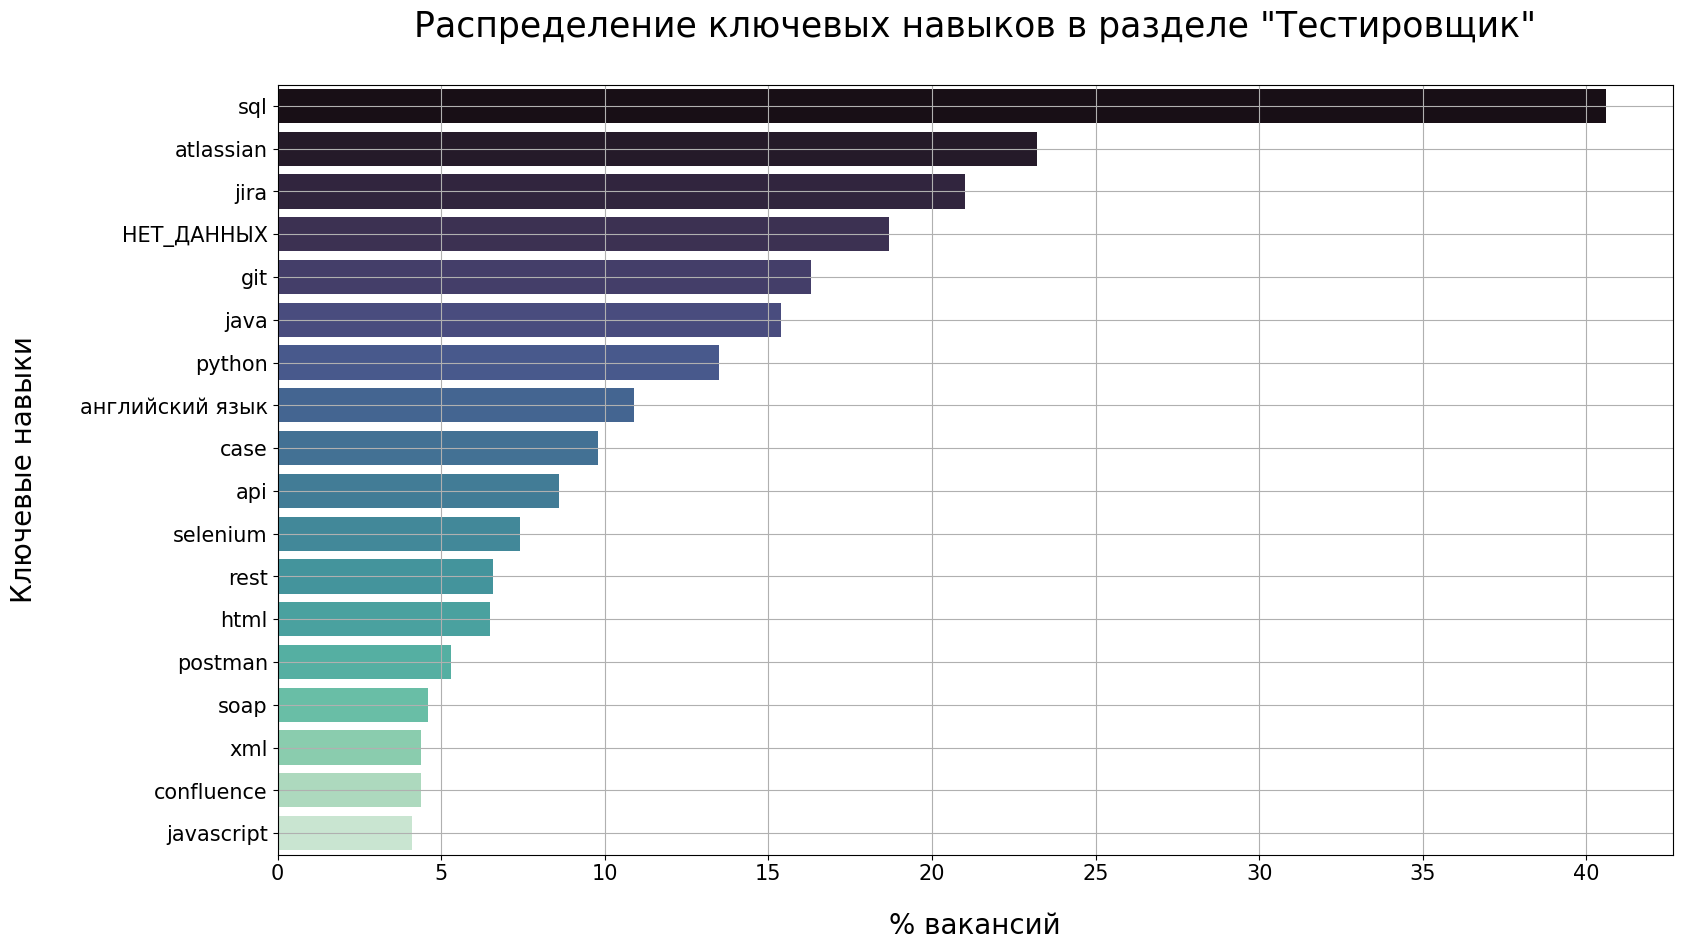

In [164]:
plt.figure(figsize=(18, 10))
sns.barplot(y=list(test_ks_main.keys()), x=list(test_ks_main.values()), palette="mako")
plt.title('Распределение ключевых навыков в разделе "Тестировщик"\n', fontsize=25)
plt.xlabel('% вакансий', fontsize=20, labelpad=20)
plt.ylabel('Ключевые навыки', fontsize=20,labelpad=30)
plt.grid('on')
plt.savefig('Тестировщик.png')
plt.show()

In [28]:
print ('Распределение навыков по операционным системам')
test_ks_os

Распределение навыков по операционным системам


{'linux': 12.8, 'android': 5.3, 'ios': 4.7}

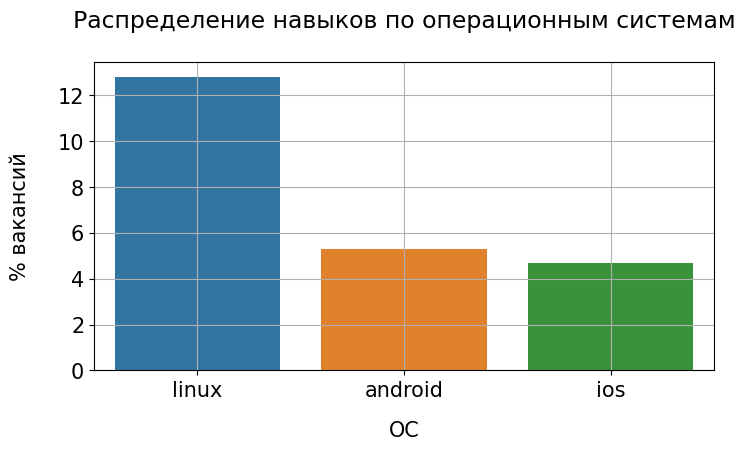

In [172]:
plt.figure(figsize=(8, 4))
sns.barplot(x=list(test_ks_os.keys()), y=list(test_ks_os.values()))
plt.title('Распределение навыков по операционным системам\n', fontsize=17)
plt.xlabel('ОС', fontsize=15, labelpad=15)
plt.ylabel('% вакансий', fontsize=15, labelpad=20)
plt.grid('on')
plt.savefig('Тестировщик_ОС.png')
plt.show()

In [30]:
print('Распределение навыков по виду тестирования')
test_ks_type

Распределение навыков по виду тестирования


{'ручное': 3.0,
 'нагрузочное': 3.5,
 'регрессионное': 6.1,
 'функциональное': 23.5}

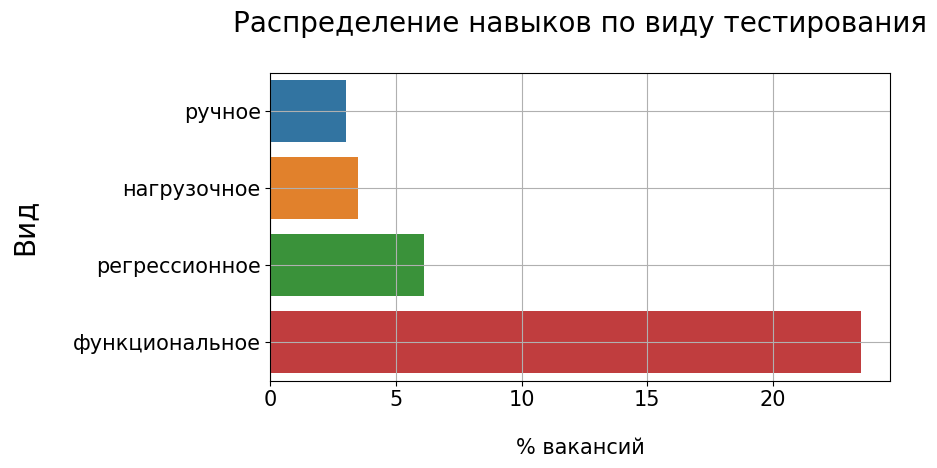

In [173]:
plt.figure(figsize=(8, 4))
sns.barplot(y=list(test_ks_type.keys()), x=list(test_ks_type.values()), orient='h')
plt.title('Распределение навыков по виду тестирования\n', fontsize=20)
plt.xlabel('% вакансий', fontsize=15, labelpad=20)
plt.ylabel('Вид', fontsize=20, labelpad=25)
plt.grid('on')
plt.savefig('Тестировщик_вид.png')
plt.show()

### 3.3 Системный инженер

In [32]:
eng_df = role_df('системный инженер')     #создаем дф для проф. роли 'Системный инженер'

eng_ks_tokens = word_freq(eng_df['s_key_skills'].to_list(), 2, '.')

print('Слова встречаются в разделе "ключевые навыки" в %')
eng_ks_tokens

Слова встречаются в разделе "ключевые навыки" в %


{'linux': 58.1,
 'настройка': 29.4,
 'docker': 25.2,
 'администрирование': 24.6,
 'пк': 21.7,
 'python': 18.7,
 'bash': 18.5,
 'НЕТ_ДАННЫХ': 17.0,
 'kubernetes': 15.9,
 'сервер': 15.7,
 'postgresql': 15.6,
 'git': 15.4,
 'ci': 14.3,
 'ansible': 13.7,
 'сетевой': 13.5,
 'sql': 13.0,
 'nginx': 12.8,
 'cd': 12.2,
 'windows': 11.5,
 'технический': 9.6,
 'подключение': 8.5,
 'английский': 8.0,
 'язык': 8.0,
 'ремонт': 7.8,
 'zabbix': 7.6,
 'jenkins': 7.2,
 'devops': 6.9,
 'обслуживание': 6.9,
 'ms': 6.9,
 'работа': 6.9,
 'gitlab': 6.7,
 'ip': 6.5,
 'mysql': 6.5,
 'tcp': 6.1,
 'информационный': 5.9,
 'оборудование': 5.6,
 'server': 4.4,
 'powershell': 4.3,
 'active': 4.3,
 'directory': 4.3,
 'grafana': 4.1,
 'centos': 3.9,
 'vmware': 3.9,
 'cisco': 3.7,
 'система': 3.7,
 'terraform': 3.5,
 'rabbitmq': 3.5,
 'пользователь': 3.5,
 'безопасность': 3.3,
 'деловой': 3.1,
 'ubuntu': 3.1,
 'база': 3.1,
 'данные': 3.1,
 'prometheus': 3.1,
 'teamcity': 3.0,
 'oracle': 2.8,
 'команда': 2.8,
 'atlassia

In [33]:
eng_ks_mass = ['linux','docker','администрирование','python','bash','НЕТ_ДАННЫХ','kubernetes','postgresql','git','ansible',
                   'sql','nginx','windows','английский','zabbix','jenkins','devops','gitlab']

eng_ks_main = get_main_mass (eng_ks_mass, eng_ks_tokens)
eng_ks_main['английский язык'] = eng_ks_main.pop('английский')
eng_ks_main = sort_dict(eng_ks_main)

print('Наиболее часто всречающиеся ключевые навыки в разделе "Системный инженер" в %')
eng_ks_main

Наиболее часто всречающиеся ключевые навыки в разделе "Системный инженер" в %


{'linux': 58.1,
 'docker': 25.2,
 'администрирование': 24.6,
 'python': 18.7,
 'bash': 18.5,
 'НЕТ_ДАННЫХ': 17.0,
 'kubernetes': 15.9,
 'postgresql': 15.6,
 'git': 15.4,
 'ansible': 13.7,
 'sql': 13.0,
 'nginx': 12.8,
 'windows': 11.5,
 'английский язык': 8.0,
 'zabbix': 7.6,
 'jenkins': 7.2,
 'devops': 6.9,
 'gitlab': 6.7}

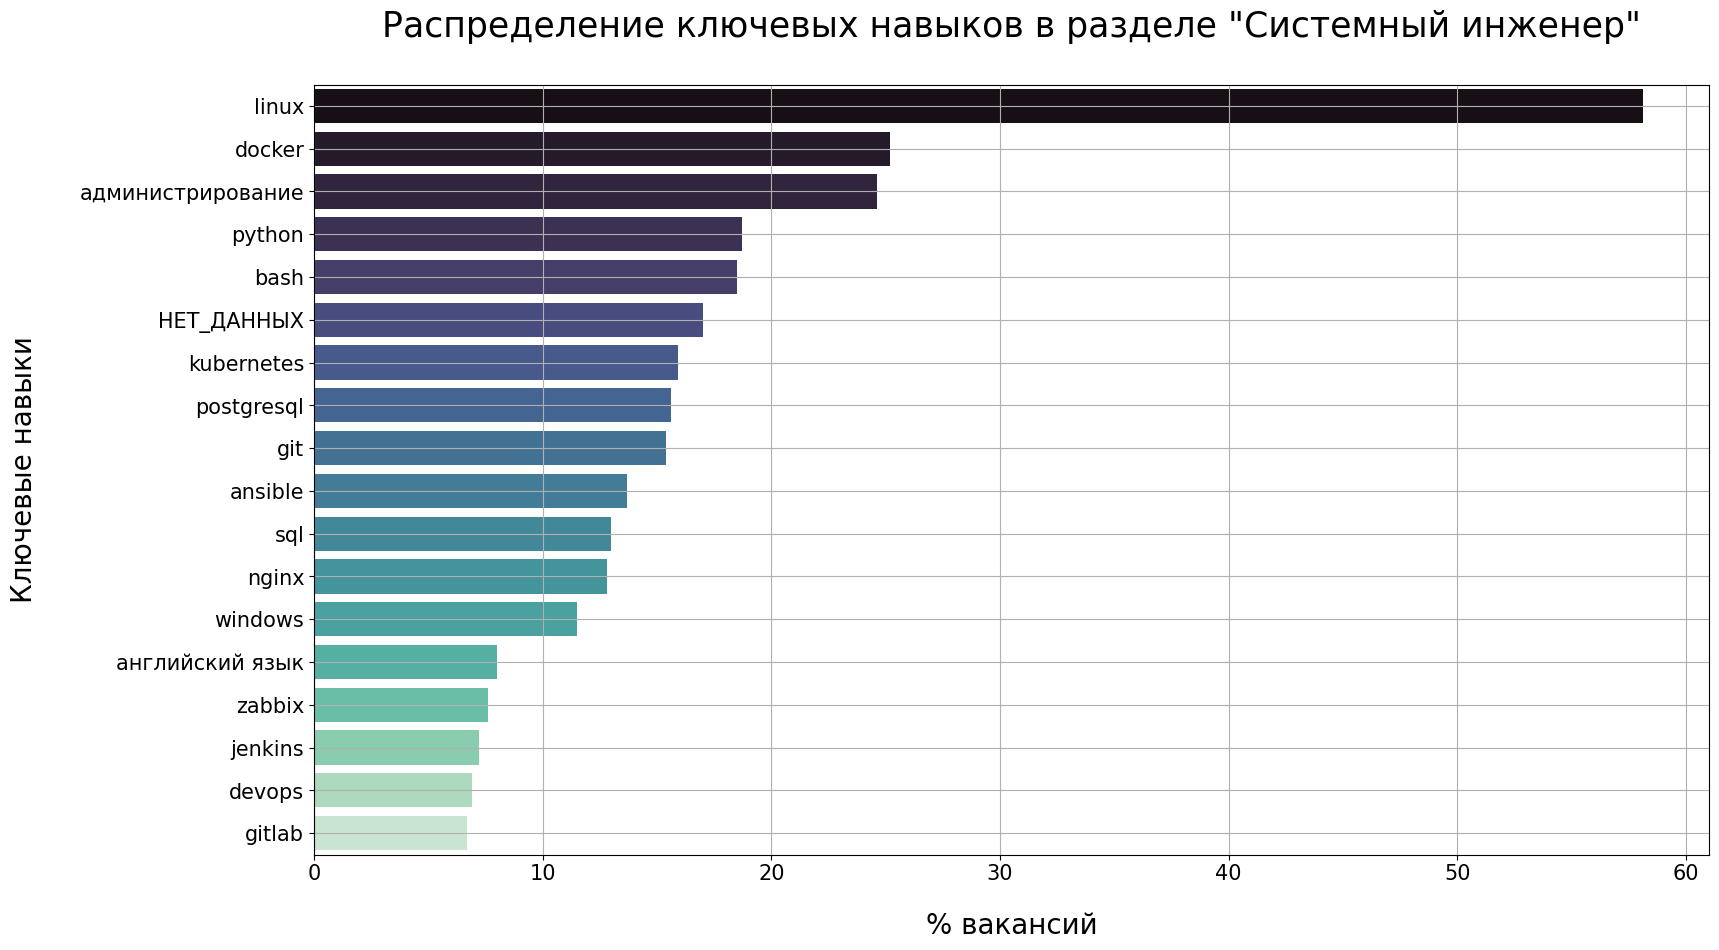

In [174]:
plt.figure(figsize=(18, 10))
sns.barplot(y=list(eng_ks_main.keys()), x=list(eng_ks_main.values()), palette="mako")
plt.title('Распределение ключевых навыков в разделе "Системный инженер"\n', fontsize=25)
plt.xlabel('% вакансий', fontsize=20, labelpad=20)
plt.ylabel('Ключевые навыки', fontsize=20,labelpad=30)
plt.grid('on')
plt.savefig('Системный инженер.png')
plt.show()

### 3.4 Гейм дизайнер  


In [35]:
game_df = role_df('гейм дизайнер')     #создаем дф для проф. роли 'Гейм дизайнер'

game_ks_tokens = word_freq(game_df['s_key_skills'].to_list(), 2, '.')

print('Слова встречаются в разделе "ключевые навыки" в %')
game_ks_tokens

Слова встречаются в разделе "ключевые навыки" в %


{'adobe': 40.9,
 'game': 28.3,
 'photoshop': 27.7,
 'unity': 27.0,
 'd': 27.0,
 'игра': 25.2,
 'разработка': 24.5,
 'design': 21.4,
 'креативность': 18.9,
 'gamedev': 18.2,
 'дизайн': 17.6,
 'компьютерный': 15.7,
 'НЕТ_ДАННЫХ': 13.2,
 'английский': 11.3,
 'язык': 11.3,
 'работа': 10.7,
 'команда': 10.1,
 'анимация': 9.4,
 'autodesk': 8.2,
 'illustrator': 7.5,
 'after': 6.9,
 'effect': 6.9,
 'ux': 6.9,
 'max': 6.9,
 'blender': 6.9,
 'maya': 6.3,
 'моделирование': 6.3,
 'designer': 5.7,
 'мышление': 5.7,
 'гейм': 5.7,
 'f': 5.7,
 'p': 5.7,
 'управление': 5.7,
 'грамотный': 5.7,
 'речь': 5.7,
 'ui': 5.7,
 'ds': 5.7,
 'spine': 5.7,
 'грамотность': 5.7,
 'ms': 5.0,
 'графический': 5.0,
 'концепция': 4.4,
 'анализ': 4.4,
 'навык': 4.4,
 'мобильный': 4.4,
 'аналитический': 4.4,
 'atlassian': 4.4,
 'графика': 4.4,
 'интерфейс': 3.8,
 'figma': 3.8,
 'проект': 3.8,
 'организаторский': 3.1,
 'рисунок': 3.1,
 'unreal': 3.1,
 'engine': 3.1,
 'график': 3.1,
 'иллюстрирование': 3.1,
 'c': 3.1,
 'мате

In [36]:
game_ks_mass = ['photoshop','unity','креативность','gamedev', 'НЕТ_ДАННЫХ','английский','autodesk','illustrator','after',
               'blender','maya','ux','spine']

game_ks_main = get_main_mass (game_ks_mass, game_ks_tokens)
game_ks_main['adobe photoshop'] = game_ks_main.pop('photoshop')
game_ks_main['adobe illustrator'] = game_ks_main.pop('illustrator')
game_ks_main['английский язык'] = game_ks_main.pop('английский')
game_ks_main['after effect'] = game_ks_main.pop('after')
game_ks_main['ux/ui'] = game_ks_main.pop('ux')
game_ks_main = sort_dict(game_ks_main)

print('Наиболее часто всречающиеся ключевые навыки в разделе "Гейм дизайнер" в %')
game_ks_main

Наиболее часто всречающиеся ключевые навыки в разделе "Гейм дизайнер" в %


{'adobe photoshop': 27.7,
 'unity': 27.0,
 'креативность': 18.9,
 'gamedev': 18.2,
 'НЕТ_ДАННЫХ': 13.2,
 'английский язык': 11.3,
 'autodesk': 8.2,
 'adobe illustrator': 7.5,
 'blender': 6.9,
 'after effect': 6.9,
 'ux/ui': 6.9,
 'maya': 6.3,
 'spine': 5.7}

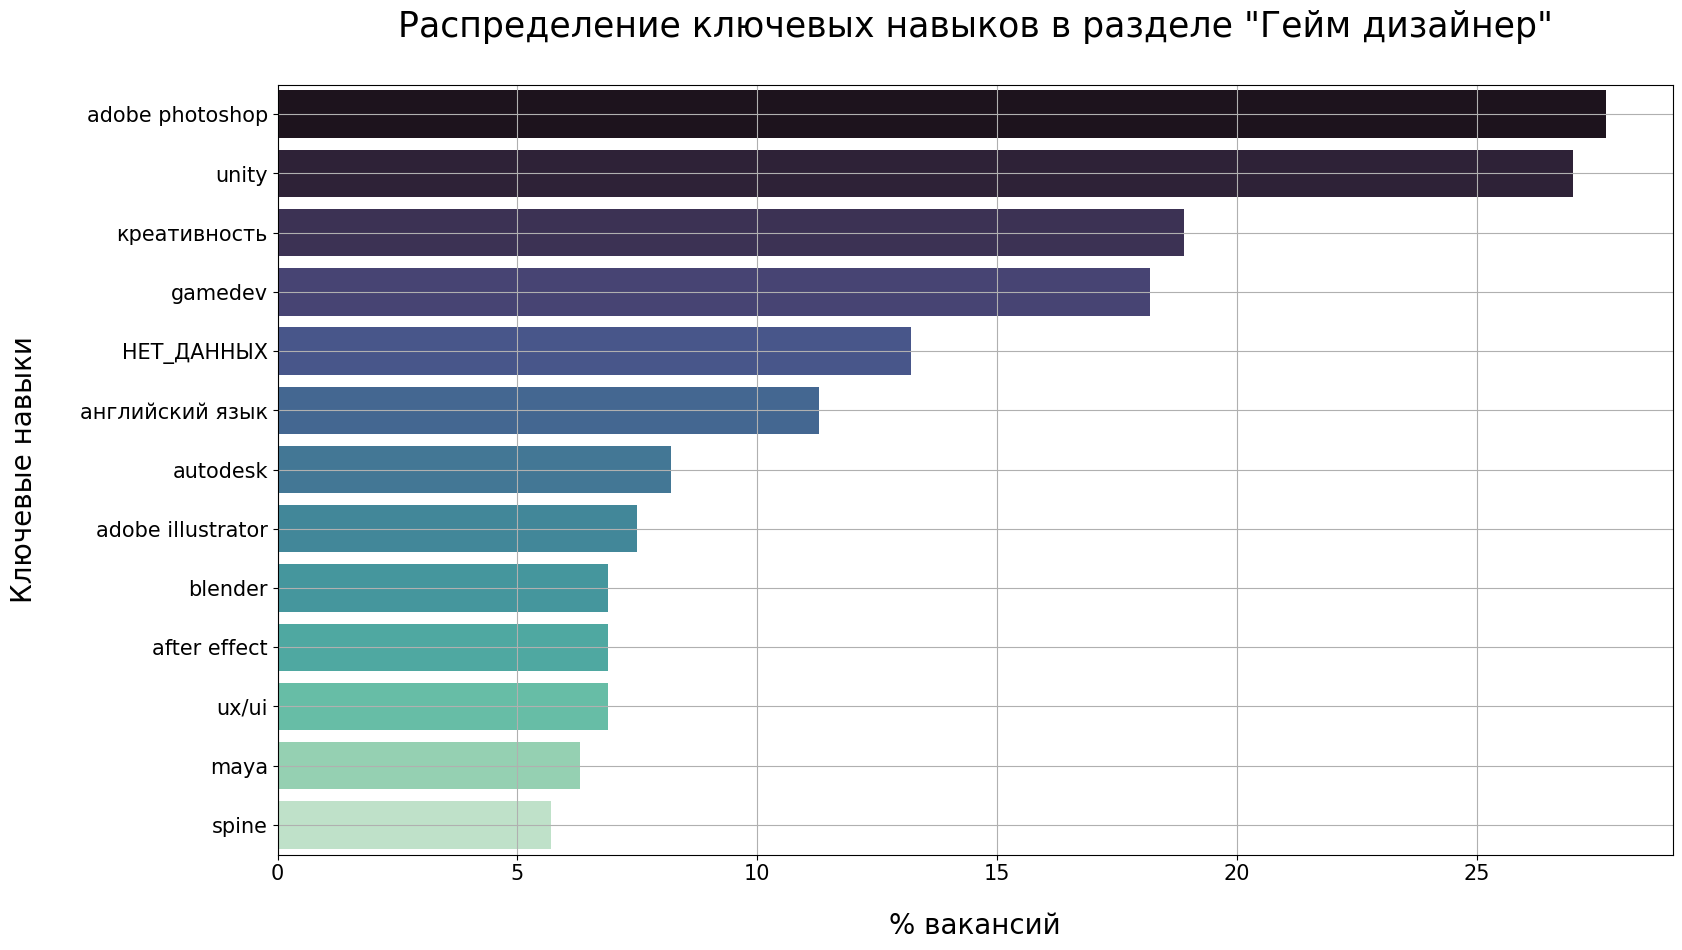

In [175]:
plt.figure(figsize=(18, 10))
sns.barplot(y=list(game_ks_main.keys()), x=list(game_ks_main.values()), palette="mako")
plt.title('Распределение ключевых навыков в разделе "Гейм дизайнер"\n', fontsize=25)
plt.xlabel('% вакансий', fontsize=20, labelpad=20)
plt.ylabel('Ключевые навыки', fontsize=20,labelpad=30)
plt.grid('on')
plt.savefig('Гейм дизайнер.png')
plt.show()